# RQ1 - Eyetracking Fixation Metrics

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import utils.GenSnippetsLib as gsl
import math
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
screen_resolution = (1920, 1080)

## Import Eyetracking Data

In [3]:
df_query = pd.read_csv("./data/filteredData/filtered_data.csv")
df_eyetracking_events = pd.DataFrame(columns=["Participant", "Algorithm", "Path"])
snippets = df_query["Algorithm"].unique()
participants = df_query["Participant"].unique()
for participant in participants:
    for snippet in snippets:
        path = f"./data/filteredData/Participant{str(participant).zfill(2)}/{snippet}_Code_eyetracking.csv"
        # check if path exists
        if os.path.exists(path):
            df_eyetracking_events.loc[len(df_eyetracking_events)] = [participant, snippet, path]
df_eyetracking_events

,Participant,Algorithm,Path
0,1,IsPrime,./data/filteredData/Participant01/IsPrime_Code...
1,1,SiebDesEratosthenes,./data/filteredData/Participant01/SiebDesErato...
2,1,IsAnagram,./data/filteredData/Participant01/IsAnagram_Co...
3,1,RemoveDoubleChar,./data/filteredData/Participant01/RemoveDouble...
4,1,BinToDecimal,./data/filteredData/Participant01/BinToDecimal...
...,...,...,...
1067,71,BogoSort,./data/filteredData/Participant71/BogoSort_Cod...
1068,71,ReverseQueue,./data/filteredData/Participant71/ReverseQueue...
1069,71,Ackerman,./data/filteredData/Participant71/Ackerman_Cod...
1070,71,RabbitTortoise,./data/filteredData/Participant71/RabbitTortoi...


In [103]:
df_filtered = pd.read_csv("./data/filteredData/filtered_data.csv")
Algorithms = df_filtered["Algorithm"].unique()
Participants = df_filtered[df_filtered["IsOutlier"] == False]["Participant"].unique()

# Calculate Metrics

In [106]:
df_fixation_per_participant = pd.DataFrame([], columns=["Algorithm", "Participant", "FixationDuration"])

for snippet in tqdm(Algorithms):
    for participant in Participants:
        df_grouped = df_eyetracking_events[(df_eyetracking_events["Participant"] == participant) &
                                           (df_eyetracking_events["Algorithm"] == snippet)]
        if len(df_grouped) == 0:
            continue

        eyetracking_path = df_grouped["Path"].values[0]
        df_current_eyetracking = pd.read_csv(eyetracking_path)
        df_fix = df_current_eyetracking[df_current_eyetracking["label"] == "FIXA"]

        for fix_idx, fix_row in df_fix.iterrows():
            fix_start = fix_row["start_time"]
            fix_end = fix_row["end_time"]
            fix_duration = fix_end - fix_start
            df_fixation_per_participant.loc[len(df_fixation_per_participant)] = [snippet, participant, fix_duration]

  0%|          | 0/32 [00:00<?, ?it/s]

In [110]:
# save the results
df_fixation_per_participant.to_csv("./data/fixation_per_participant.csv", index=False)

In [4]:
# load the results
df_fixation_per_participant = pd.read_csv("./data/fixation_per_participant.csv")

# Clean Up the Data

In [5]:
df_fixation_per_participant = df_fixation_per_participant[df_fixation_per_participant["FixationDuration"] < 1.0]

# Plot the results

In [6]:
df_skill = pd.read_csv("./data/filteredData/filtered_data.csv")
df_skill = df_skill[df_skill["IsOutlier"] == False][["Participant", "Algorithm", "SkillScore", "Duration"]]

# count the number of fixations per participant per Algorithm
df_fixation_count = df_fixation_per_participant.groupby(["Algorithm", "Participant"]).agg(
    {"FixationDuration": "count"}).reset_index()

# merge in the dataframe on Participant and Algorithm
df_fixation_count = df_fixation_count.merge(df_skill, on=["Participant", "Algorithm"])

## Fixation Count

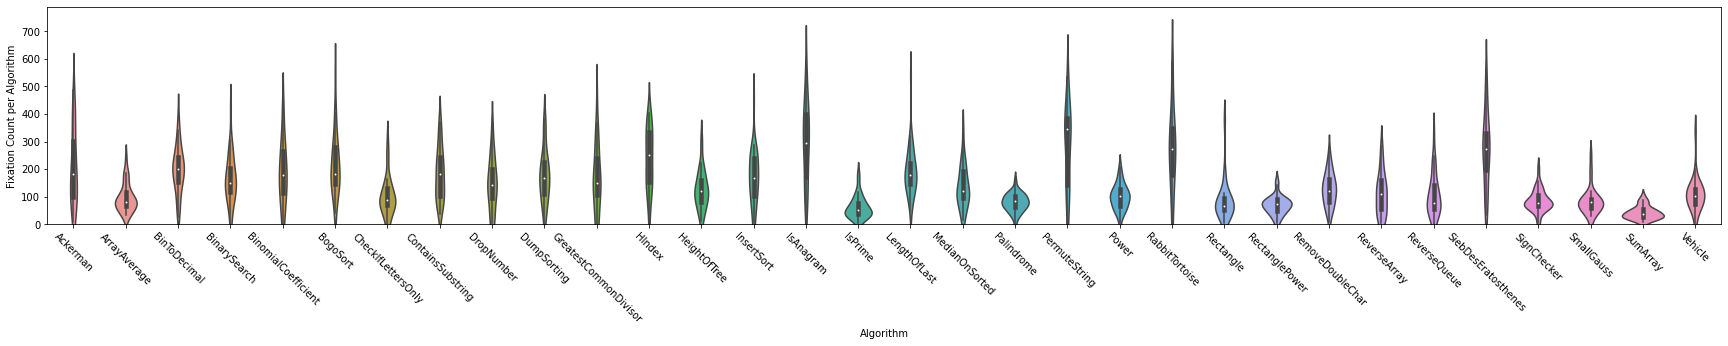

In [7]:
# plot the fixation count per algorithm
plt.figure(figsize=(30, 4))
sns.violinplot(x="Algorithm", y="FixationDuration", data=df_fixation_count)
# set the rotation of the x labels
plt.xticks(rotation=-45)
plt.ylabel("Fixation Count per Algorithm")
plt.ylim(0,)
plt.show()

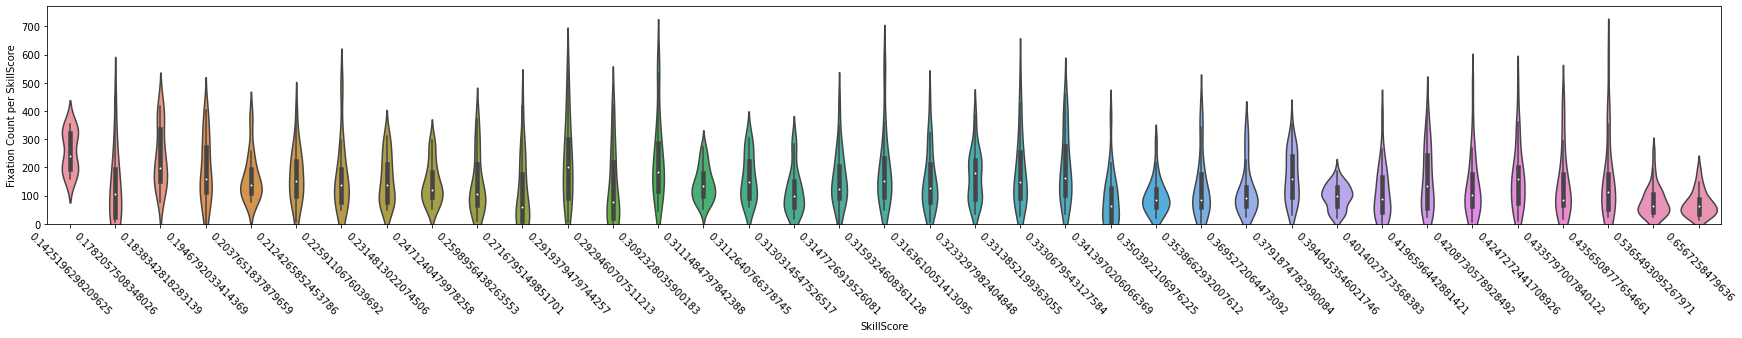

In [8]:
# plot the fixation count per SkillScoreValue
plt.figure(figsize=(30, 4))
df_tmp = df_fixation_count.copy()
df_tmp = df_tmp.sort_values(by=["SkillScore"])
sns.violinplot(x="SkillScore", y="FixationDuration", data=df_fixation_count)
# set the rotation of the x labels
plt.xticks(rotation=-45)
plt.ylabel("Fixation Count per SkillScore")
plt.ylim(0,)
plt.show()

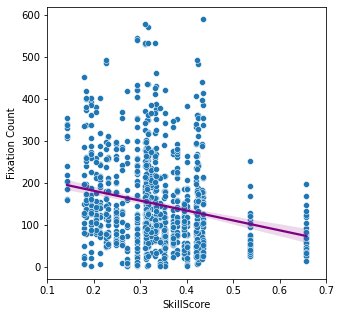

In [9]:
# plot SkillScore vs FixationCount
plt.figure(figsize=(5, 5))
sns.scatterplot(x="SkillScore", y="FixationDuration", data=df_fixation_count)
sns.regplot(x="SkillScore", y="FixationDuration", data=df_fixation_count, scatter=False, color="purple")
plt.ylabel("Fixation Count")
plt.xlim(0.1,0.7)
plt.show()

In [10]:
# calculate the correlation between SkillScore and FixationCount
df_fixation_count["FixationDuration"].corr(df_fixation_count["SkillScore"])

-0.21865981468196055

## Fixation Duration

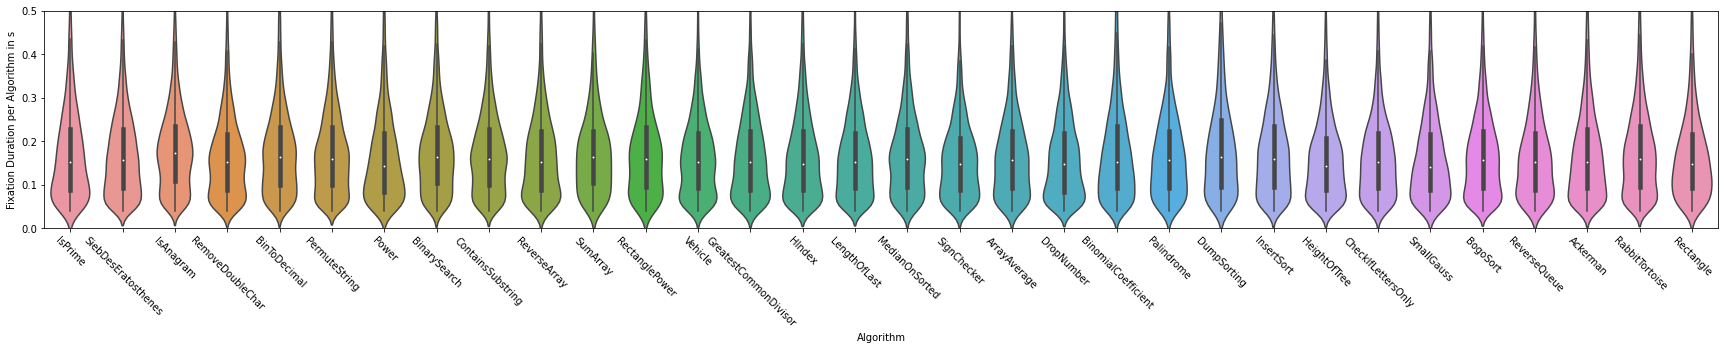

In [13]:
# plot the fixation duration per algorithm
plt.figure(figsize=(30, 4))
sns.violinplot(x="Algorithm", y="FixationDuration", data=df_fixation_per_participant)
# set the rotation of the x labels
plt.xticks(rotation=-45)
plt.ylabel("Fixation Duration per Algorithm in s")
plt.ylim(0,0.5)
plt.show()

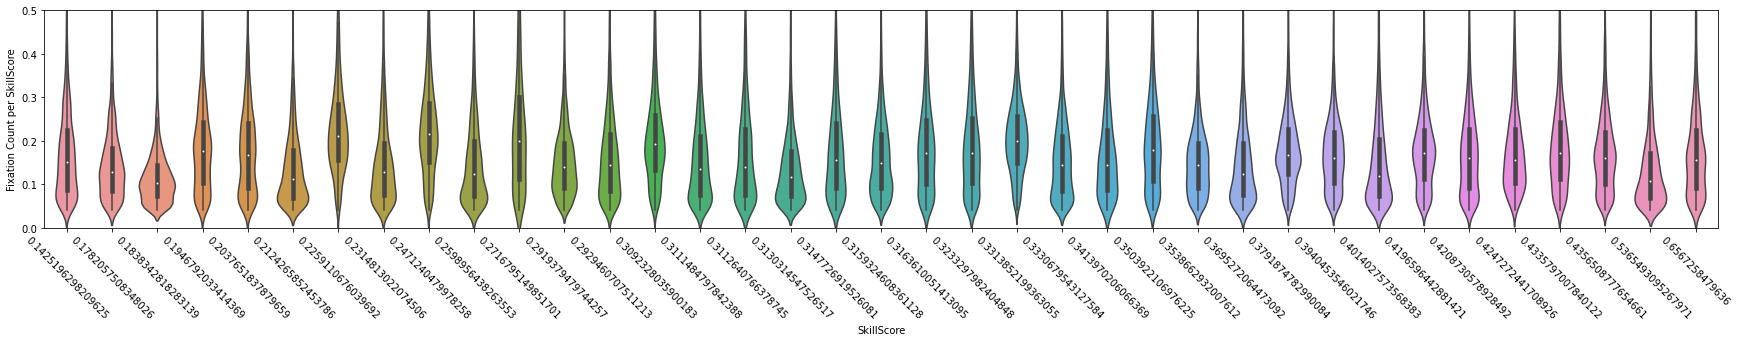

In [14]:
# plot the fixation duration per SkillScoreValue
plt.figure(figsize=(30, 4))
df_tmp = df_fixation_per_participant.copy()
df_tmp = pd.merge(df_tmp, df_skill, on=["Participant", "Algorithm"])
df_tmp = df_tmp.sort_values(by=["SkillScore"])
sns.violinplot(x="SkillScore", y="FixationDuration", data=df_tmp)
# set the rotation of the x labels
plt.xticks(rotation=-45)
plt.ylabel("Fixation Count per SkillScore")
plt.ylim(0,0.5)
plt.show()

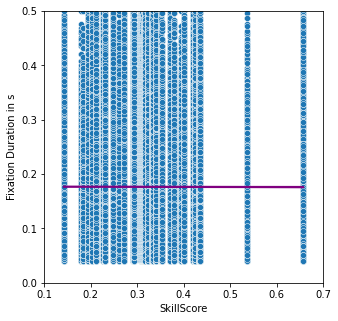

In [152]:
# plot SkillScore vs FixationDuration
plt.figure(figsize=(5, 5))
df_tmp = df_fixation_per_participant.copy()
df_tmp = pd.merge(df_tmp, df_skill, on=["Participant", "Algorithm"])
df_tmp = df_tmp.sort_values(by=["SkillScore"])
sns.scatterplot(x="SkillScore", y="FixationDuration", data=df_tmp)
sns.regplot(x="SkillScore", y="FixationDuration", data=df_tmp, scatter=False, color="purple")
plt.ylabel("Fixation Duration in s")
plt.ylim(0,0.5)
plt.xlim(0.1,0.7)
plt.show()

In [153]:
# calculate the correlation between SkillScore and FixationDuration
df_tmp = df_fixation_per_participant.copy()
df_tmp = pd.merge(df_tmp, df_skill, on=["Participant", "Algorithm"])
df_tmp = df_tmp.sort_values(by=["SkillScore"])
df_tmp["FixationDuration"].corr(df_tmp["SkillScore"])

-0.0008387257218061355